In [3]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

!git clone https://github.com/IDEA-Research/GroundingDINO   
%cd GroundingDINO   
!pip install -e .

! pip install diffusers transformers accelerate scipy safetensors

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-tdp8yqks
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-tdp8yqks
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 463 (delta 175), reused 135 (delta 135), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 26.68 MiB/s, done.
Resolving deltas: 100% (241/241), done.
/kaggle/working/GroundingDINO
Obtaining file:///kaggle/working/GroundingDINO
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 2.2 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
import torch
from huggingface_hub import hf_hub_download
from groundingdino.util.slconfig import SLConfig
from groundingdino.models import build_model
from groundingdino.util.utils import clean_state_dict
from groundingdino.util.inference import annotate, predict
from groundingdino.util.inference import load_image as dino_load_image
from PIL import Image
import numpy as np
from torchvision.ops import box_convert
import cv2

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    return image_np, image

def annotate(image_source, boxes, logits, phrases):
    return image_source

def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])

    h, w = mask.shape[-2:]
    mask_image = mask.cpu().reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.numpy() * 255).astype(np.uint8)).convert("RGBA")
    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))


def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)
    args = SLConfig.fromfile(cache_config_file)
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print(f"Model loaded from {cache_file} \n => {log}")
    model.eval()
    return model


In [7]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filename = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filename, ckpt_config_filename, device='cuda' if torch.cuda.is_available() else 'cpu')

GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [8]:
from segment_anything import SamPredictor, build_sam


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sam_checkpoint = '/kaggle/input/avataar/Avataar/sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float32
).to(device)

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [10]:
local_image_path = '/kaggle/input/avataar/wall hanging.jpg'
TEXT_PROMPT = "wall hanging"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

image_source, image = dino_load_image(local_image_path)

boxes, logits, phrases = predict(
    model=groundingdino_model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
    device=DEVICE
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[..., ::-1]

annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

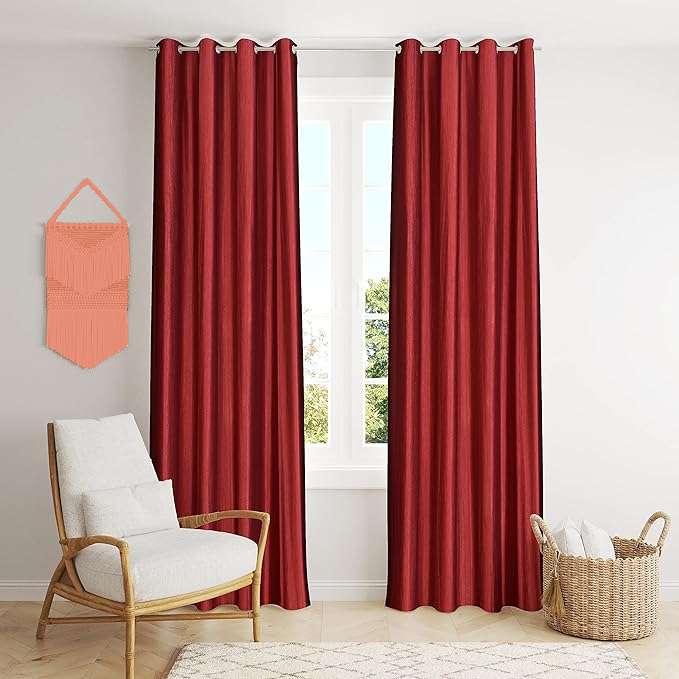

In [11]:
sam_predictor.set_image(image_source)

H, W, _ = image_source.shape
boxes_xyxy = box_convert(boxes, 'cxcywh', 'xyxy') * torch.Tensor([W, H, W, H])
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(DEVICE)

masks, _, _ = sam_predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)

Image.fromarray(annotated_frame_with_mask)


In [45]:

from scipy.ndimage import gaussian_filter
from skimage import exposure

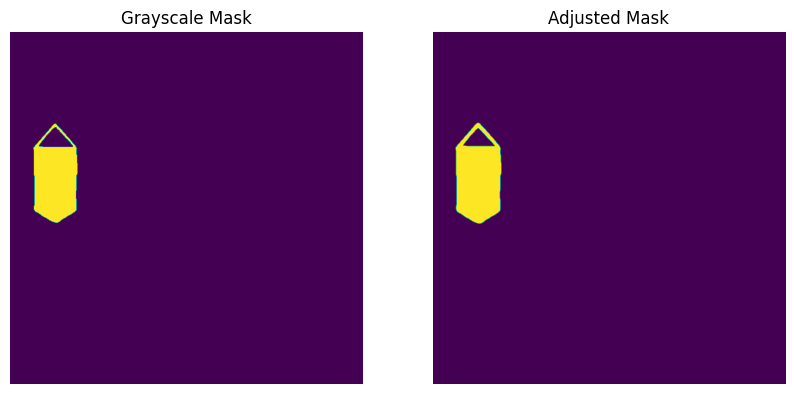

In [56]:
import torch
from torchvision.ops import box_convert
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import exposure

selected_mask = masks[0].cpu().numpy()

def binary_to_grayscale(binary_image):
    grayscale_image = binary_image.astype(np.float32) * 255.0
    return grayscale_image

# Apply Gaussian blur
def apply_gaussian_blur(image, sigma=1):
    blurred_image = gaussian_filter(image, sigma=sigma)
    return blurred_image

# Adjust contrast using gamma correction
def adjust_contrast(image, gamma=1.0):
    adjusted_image = exposure.adjust_gamma(image, gamma)
    return adjusted_image

# Processing the mask
grayscale_mask = binary_to_grayscale(selected_mask)

# Removing the singleton dimension for imshow compatibility
grayscale_mask = np.squeeze(grayscale_mask)

# Applying blur and contrast adjustment
blurred_mask = apply_gaussian_blur(grayscale_mask, sigma=1)
adjusted_mask = adjust_contrast(blurred_mask, gamma=1.9)

# Ensure mask values are in the valid range for displaying
adjusted_mask = np.clip(adjusted_mask, 0, 255).astype(np.uint8)

# Plotting the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Grayscale Mask")
plt.imshow(grayscale_mask)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Adjusted Mask")
plt.imshow(adjusted_mask)
plt.axis('off')

plt.show()

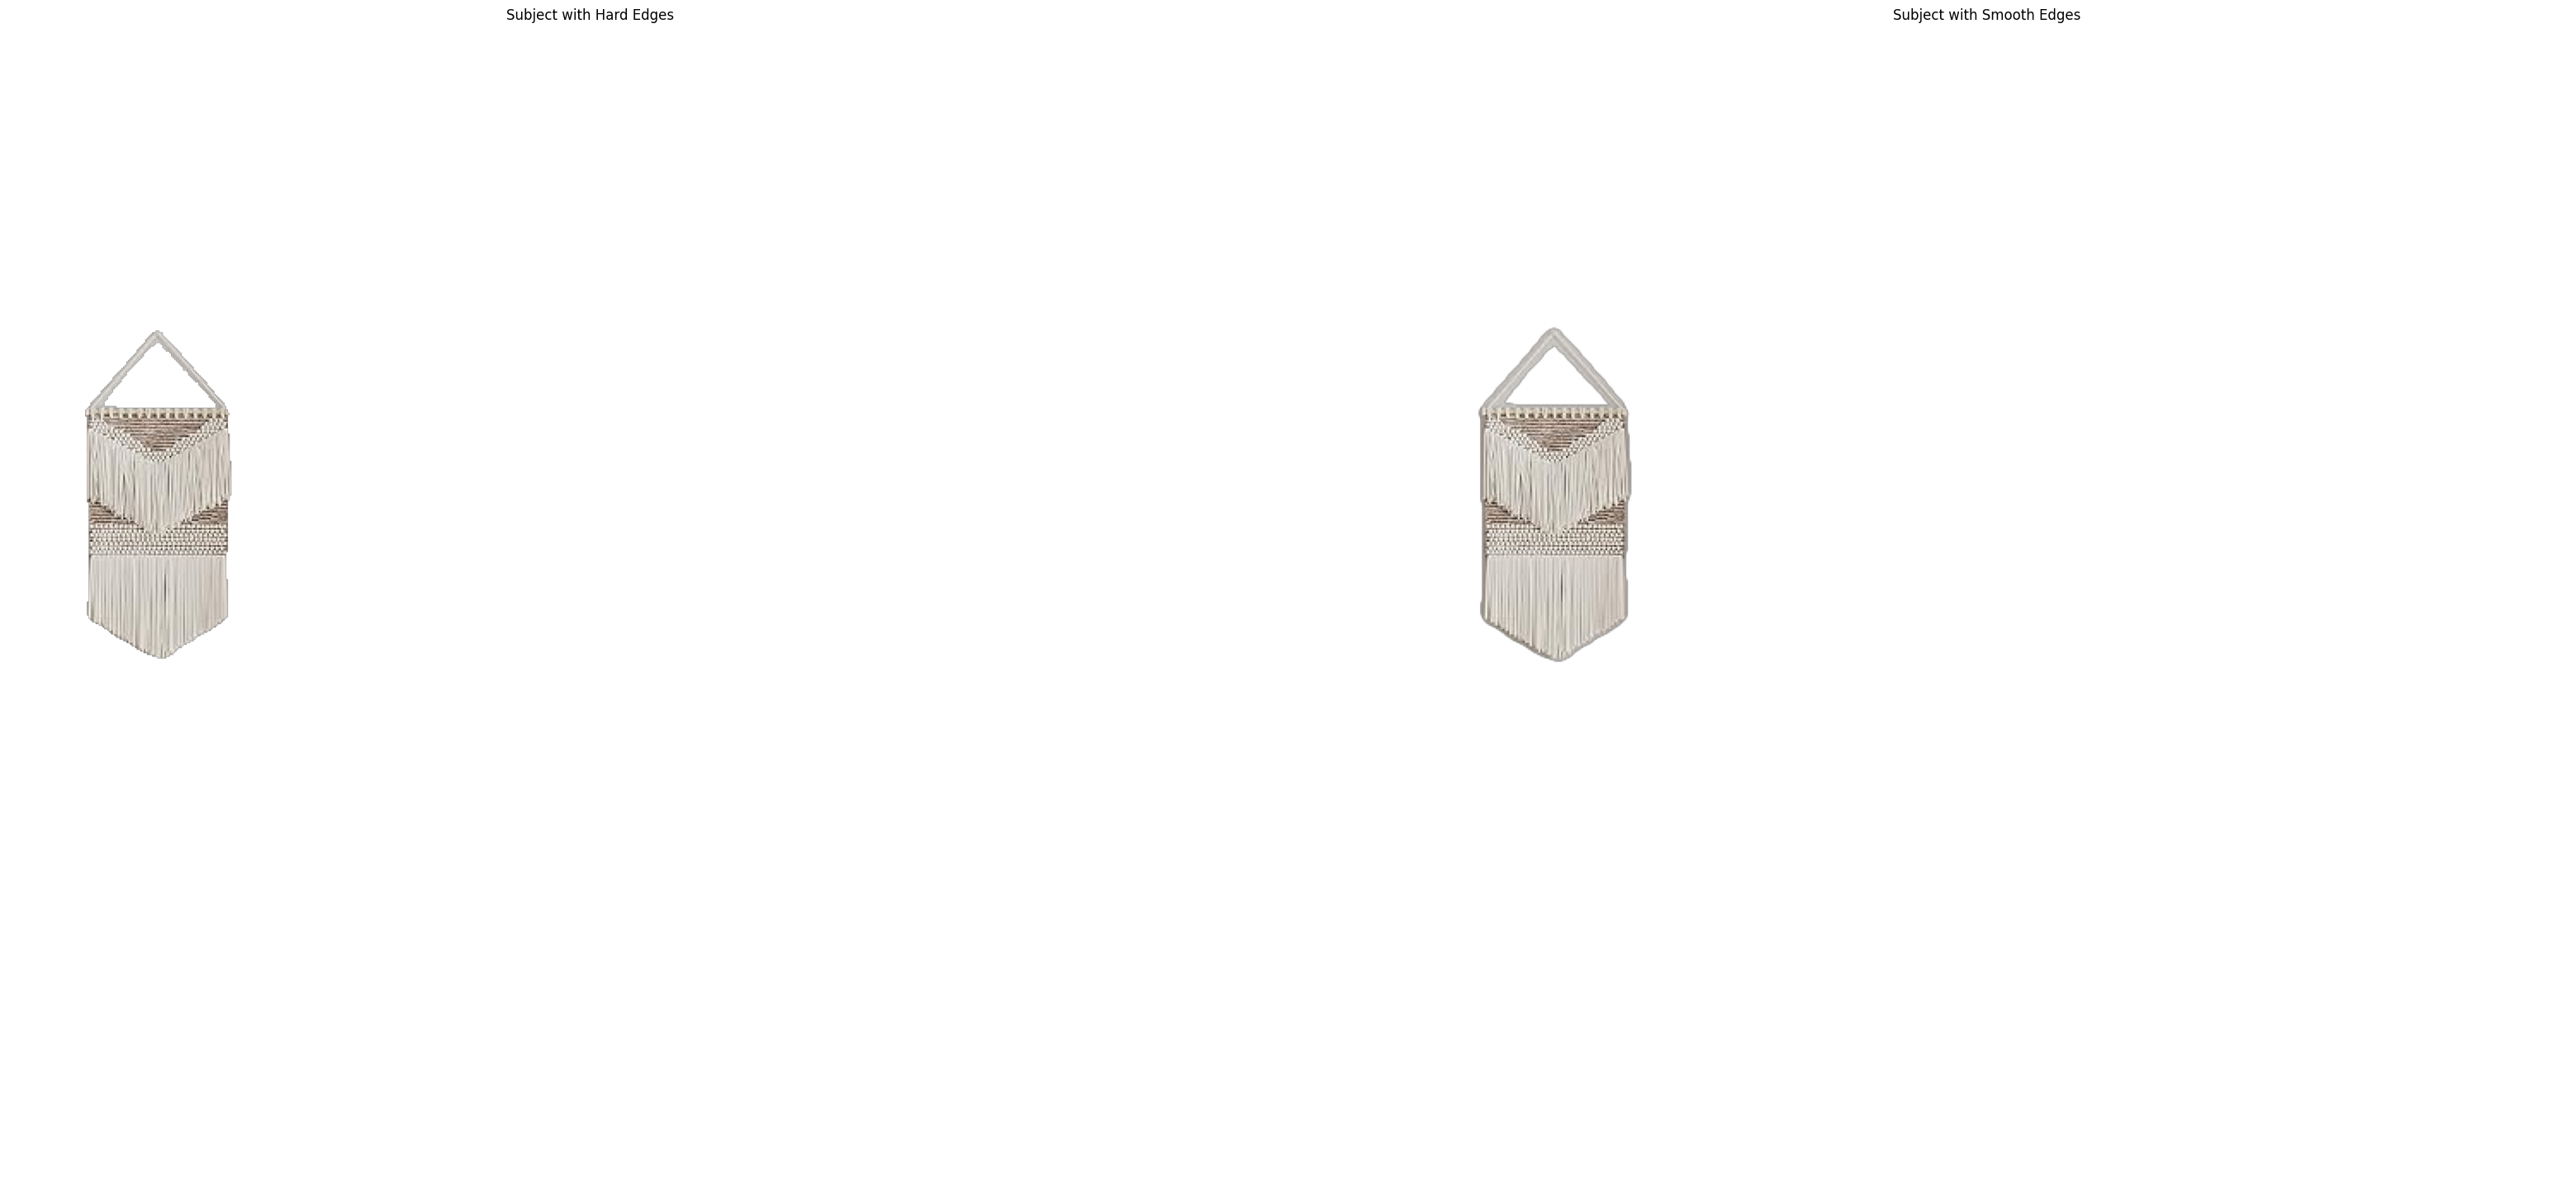

True

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

height, width, _ = image_rgb.shape
subject_image_rgba_1 = np.zeros((height, width, 4), dtype=np.uint8)
subject_image_rgba_1[..., :3] = (image_rgb * (adjusted_mask[..., np.newaxis] / 255)).astype(np.uint8)
subject_image_rgba_1[..., 3] = adjusted_mask

subject_image_rgba_2 = np.zeros((height, width, 4), dtype=np.uint8)
subject_image_rgba_2[..., :3] = np.where(selected_mask[..., np.newaxis], image_rgb, 0)
subject_image_rgba_2[..., 3] = np.where(selected_mask, 255, 0)

fig, axes = plt.subplots(1, 2, figsize=(40, 30))

axes[0].imshow(subject_image_rgba_2)
axes[0].set_title("Subject with Hard Edges")
axes[0].axis('off')

axes[1].imshow(subject_image_rgba_1)
axes[1].set_title("Subject with Smooth Edges")
axes[1].axis('off')


plt.show()

cv2.imwrite("subject.png", cv2.cvtColor(subject_image_rgba_1, cv2.COLOR_RGBA2BGRA))

In [59]:
import matplotlib.pyplot as plt

[41.28820037841797, 177.2525634765625, 132.235107421875, 370.7630615234375]


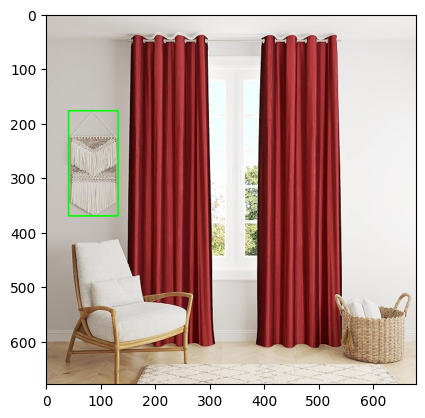

In [60]:
image = cv2.imread("/kaggle/input/avataar/wall hanging.jpg")
boxes_xyxy = box_convert(boxes, 'cxcywh', 'xyxy') * torch.Tensor([W, H, W, H])
box = boxes_xyxy.cpu().numpy().tolist()[0]
print(box)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
# Image.fromarray(image)
plt.imshow(image)




(679, 679)


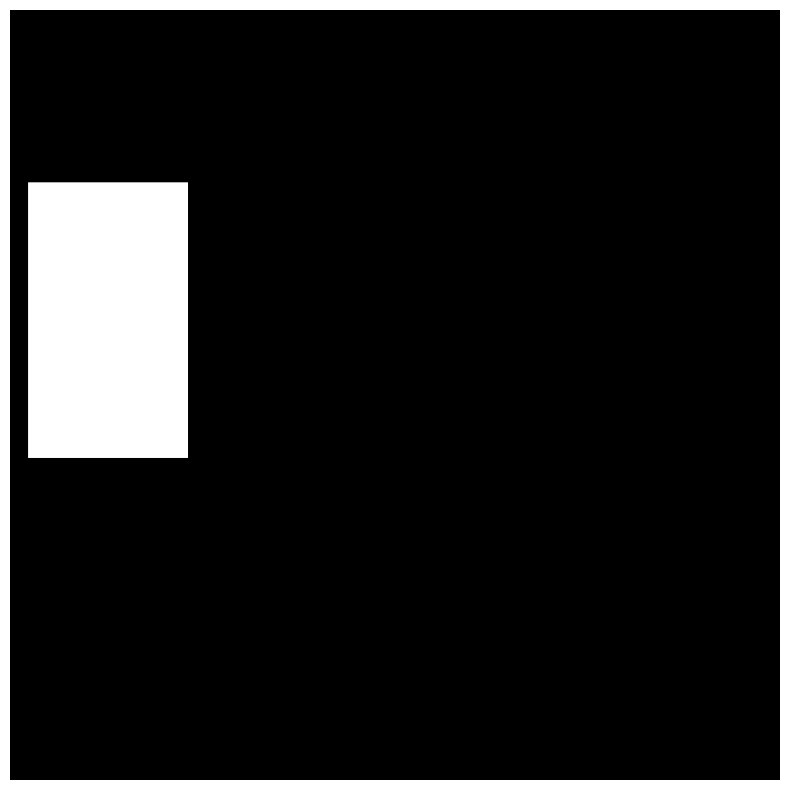

In [34]:
rect_mask = np.zeros((H, W), dtype=np.uint8)
print(rect_mask.shape)

padding = 25
y0 = max(0,(int(box[1])-padding))
x0 = max(0, (int(box[0])-padding))
y1 = min((rect_mask.shape)[0],(int(box[3])+25))
x1 = min((rect_mask.shape)[1],(int(box[2])+25))
rect_mask[y0:y1,x0:x1] = 255

mask_pil = Image.fromarray(rect_mask)

plt.figure(figsize=(10, 10))
plt.imshow(mask_pil, cmap="gray")
plt.axis('off')
plt.show()


In [35]:
image_pil = Image.fromarray(image)

  0%|          | 0/50 [00:00<?, ?it/s]

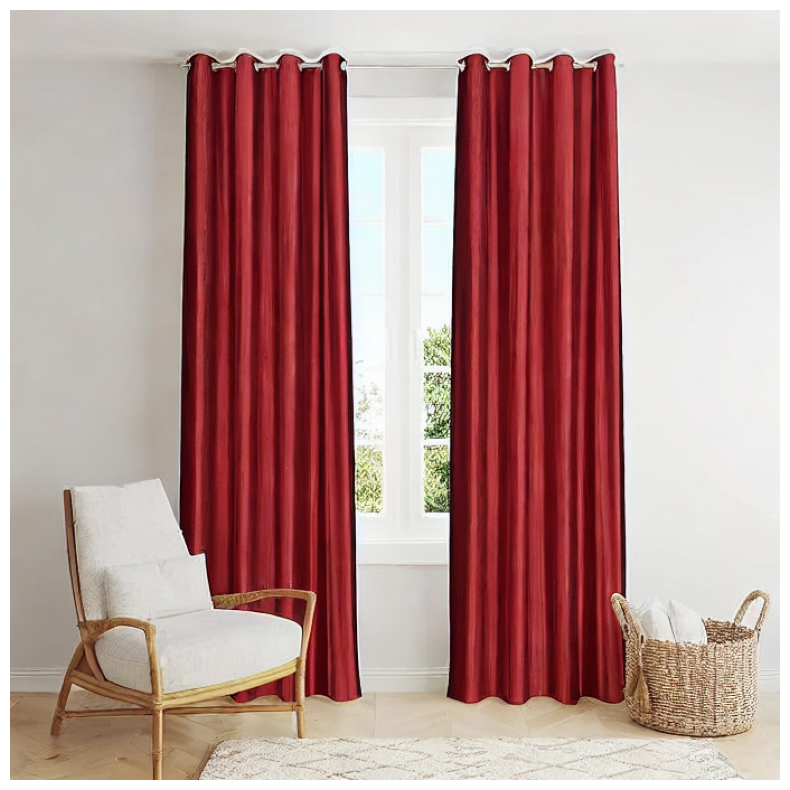

<PIL.Image.Image image mode=RGB size=688x688 at 0x7B34CFF32410>
688 688 679 679
4.5
4.5


In [61]:
import math

prompt = "blend into the background"
negative_prompt = "noise, poster, objects, bookstack, characters, distinct elements, people,pots flower, plant, cup, painting, shoes, utensils, shelves, rack, table, basket, anything, bag, pouch, book, lamp, ball, bat, laptop, computer, device, keyboard, notebook, pen, paper, bottle, art, supplies, wine"
height = 16*math.ceil(H/16)
width = 16*math.ceil(W/16)
inpainted_image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=image_pil,
    mask_image=mask_pil,
    num_inference_steps=50,
    guidance_scale=15,
    height = height,
    width = width
    

).images[0]

plt.figure(figsize=(10, 10))
plt.imshow(inpainted_image)
plt.axis('off')
plt.show()


h_diff = (height - H)/2
w_diff = (width - W)/2


inpainted_image = inpainted_image.crop((w_diff,h_diff,(W-w_diff),(H-h_diff)))

height = H
width = W

inpainted_image.save("final_inpainted_image.jpg")


In [77]:
try:
    y_shift = int(input("How many pixels down do you want the object to move? (Negative for up): "))
    x_shift = int(input("How many pixels to the right do you want the object to move? (Negative for left): "))
except ValueError:
    print("Invalid input. Using default shifts of 10 pixels in each dimension")
    y_shift = 10
    x_shift = 10

How many pixels down do you want the object to move? (Negative for up):  0
How many pixels to the right do you want the object to move? (Negative for left):  520


In [78]:
final_inpainted_image = Image.open("/kaggle/working/GroundingDINO/final_inpainted_image.jpg")

subject_image = Image.open("/kaggle/working/GroundingDINO/subject.png")

subject_image = subject_image.resize(subject_image.size,Image.Resampling.LANCZOS)
final_image = final_inpainted_image.copy()
final_image.paste(subject_image, (x_shift, y_shift), subject_image)

679 679


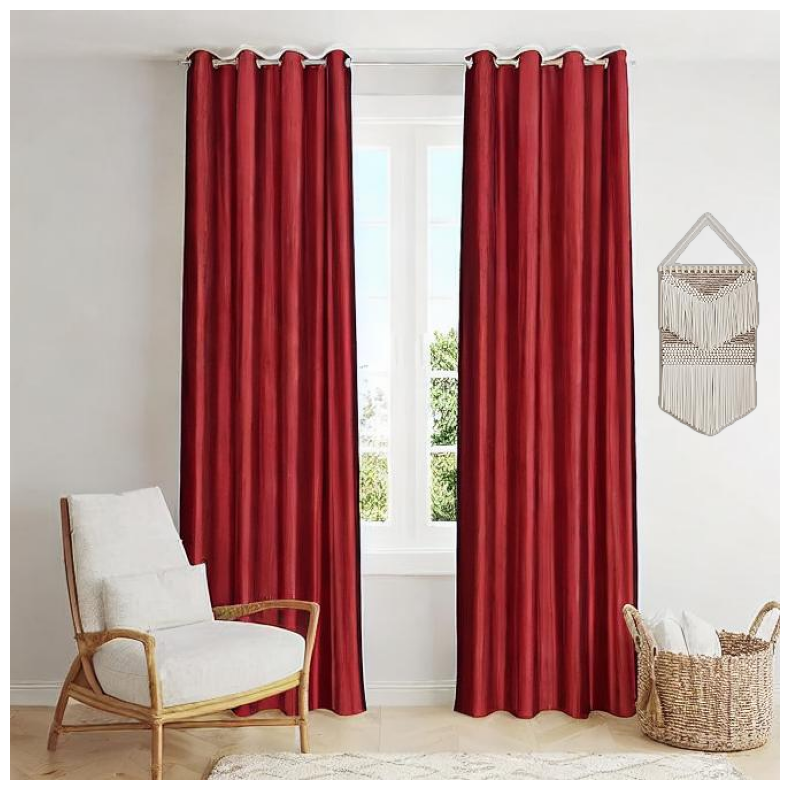

In [79]:
print(height,width)
# if extended == 1:
#     final_image = final_image.crop((100,100,(width-100),(height-100)))
final_image.save("final_image_PIL.png")
plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.axis('off')
plt.show()